# 💡 How2DDDA: **"Implicit Function Theory — from Mathematics to Automated Machine Scientist Applications"**

> All code and examples are shared to help researchers, students, and engineers understand the reasoning behind DDDA — and to make it easy to apply dimensional analysis to your own data.  
> This notebook serves as an entry-level guide for teaching, validating physical models, and enabling domain-specific knowledge engineering through data-driven dimensional reasoning.

---

## 🎯 What You'll Learn

**隐函数理论 - 机器科学家应用**

In this notebook, we will walk through the theoretical and computational foundation of **dimensional analysis**, with a focus on the **Buckingham Pi theorem**. You will learn:

1. **The motivation behind dimensional analysis**  
   Understand why we reduce variables and how dimensional consistency enables model generalization.

2. **How to construct the dimensional matrix (D-matrix)**  
   Encode physical units of input quantities using base units and build the D-matrix.

3. **How to compute Π-groups using null space techniques**  
   Discover dimensionless groups by solving linear algebraic equations on the D-matrix.

4. **How to interpret and validate Π-groups**  
   Learn to assess whether derived groups make physical and computational sense.

5. **How to extend the method toward data-driven workflows**  
   Set the stage for further steps in the DDDA pipeline including Pi-group selection, uncertainty quantification, and regime detection.

---

## 👤 Author

- **Name**: Jiashun Pang  
- **Created**: August 2025  
- **Affiliation**: DDDA Project, open research notebook  
- **Notebook Focus**:  
  A hands-on exploration of dimensional analysis — from aggregated raw quantities to symbolic Pi-group discovery and preparation for downstream DDDA tasks.

---

📌 *This notebook is designed to be accessible for learners new to dimensional analysis, while also laying the foundation for advanced applications in the full DDDA pipeline.*


## 1 · Implicit Function Theorem — General Multivariable Form & Geometry

- 一段“严格表述”的占位（multi-variate, multi-dependent 统一形式）。

- 一段“直观几何解读”的占位（水平集、法向/切向、图像表示）。

- 统一符号表与可复用的记号约定（后续章节复用）。

- 2 个代码骨架：Jacobian 可逆性检查（SymPy）+ 局部线性近似的可视化占位（稍后补画图）。

### 域的直积分解与符号

假如我们从**学科数据库**或**复杂的实验机器人**中随机获取了一组物理变量，我们希望回答两个核心问题：

* 这些变量之间**是否存在物理关系**？
* 如果存在，**这种关系的数学形式**是什么？

此时，我们可以利用**隐函数定理**的性质，实现这一过程的自动化判定与分析。

---

### 1). 获得变量集合(物理量层面)

假设通过上述途径，我们获得了 $n$ 个独立的物理量，记为：

$$Q_1, Q_2, \dots, Q_n$$

其中每个 $Q_i$ 都是定义在某个物理域的实数变量（如速度、温度、压力等）。

我们可以将变量总数写作：

$$
n = m + k
$$

其中：

* $m$：自变量（independent variables）的维数；
* $k$：因变量（dependent variables）的维数。

> 在这一阶段，我们**不预先指定**哪些 $Q_i$ 属于自变量或因变量，后续将引入自动判定方法。

---

### 2) 打包成向量（数学化）

为便于统一处理，将所有物理量按顺序排列成一个 $n$ 维列向量：

$$
z := (Q_1, Q_2, \dots, Q_{m+k})^\mathrm{T} \in \mathbb{R}^{m+k}.
$$

这里的 $z$ 是“所有输入变量”的整体表示。

---

### 3) 变量分块（隐函数定理的入口）

在数学建模中，我们可以将 $z$ 划分为两个互不相交的子块：

$$
x := (Q_{i_1}, \dots, Q_{i_m}) \in \mathbb{R}^m, 
\quad 
y := (Q_{j_1}, \dots, Q_{j_k}) \in \mathbb{R}^k,
$$

其中：

$$
\{i_1, \dots, i_m\} \cup \{j_1, \dots, j_k\} = \{1, \dots, m+k\}, \quad \{i_\alpha\} \cap \{j_\beta\} = \varnothing.
$$

* $x$：**自变量块**（independent variables）
* $y$：**因变量块**（dependent variables）

> 在我们的自动方法中，这一分块将由算法根据可解性条件自动判定，而非人工指定。

---

### 4) 建立隐函数形式的约束方程

系统的物理规律可表示为 $k$ 条独立方程：

$$
F(x, y) = 0, \quad F : \mathbb{R}^m \times \mathbb{R}^k \to \mathbb{R}^k.
$$

这里：

* **定义域**：自变量块 $x$ 与因变量块 $y$ 共同构成 $\mathbb{R}^m \times \mathbb{R}^k$；
* **值域**：$\mathbb{R}^k$，因为有 $k$ 条方程，每条方程的输出是一个实数，合起来就是 $k$ 维向量。

在**自动判定**的语境下，我们也可以直接写作：

$$
F(Q_1, Q_2, \dots, Q_{m+k}) = 0
$$

表示这些物理量之间存在某种隐式关系。

---


## 例子设定

我们使用自制的**无空气阻力的抛体运动模型**在给定两条约束方程时的数据来进行**基点选择**与**可解性判定**的完整演示。

* 选自变量块：$x=(R,H)$（水平射程、最高点高度）
* 选因变量块：$y=(v_0,\theta)$（初速度、发射角）
* 约束（$k=2$ 条）：

**运动学公式：**
  $$
  R = \frac{v_0^2\sin(2\theta)}{g}, \quad H = \frac{v_0^2\sin^2\theta}{2g}
  $$

将它们改写成**零等式形式：**
  $$
  \begin{aligned}
  F_1(x,y)&=R-\frac{v_0^2\sin(2\theta)}{g}=0,\\
  F_2(x,y)&=H-\frac{v_0^2\sin^2\theta}{2g}=0.
  \end{aligned}
  $$

  于是 $F:\mathbb{R}^2\times\mathbb{R}^2\to\mathbb{R}^2$。

我们通过将随机自变量作为初始条件，对约束方程进行离散化处理，最终我们会得到两组因变量数据数组 **$R$：射程（水平位移的最大值）** 和 **$H$：最高点高度** 。


之后我们将包含已知的重力在内的五列数组保存为"ift_projectile_samples.csv"。

---

Saved to ift_projectile_samples.csv


,v0_mps,theta_deg,R_m,H_m,g_mps2
0,47.567583,67.319708,164.117239,98.178568,9.81
1,29.138314,15.764177,45.258010,3.194042,9.81
2,52.222886,47.885443,276.596126,76.489673,9.81
3,43.355242,46.137830,191.457143,49.804125,9.81
4,10.179754,73.605772,5.720516,4.860969,9.81


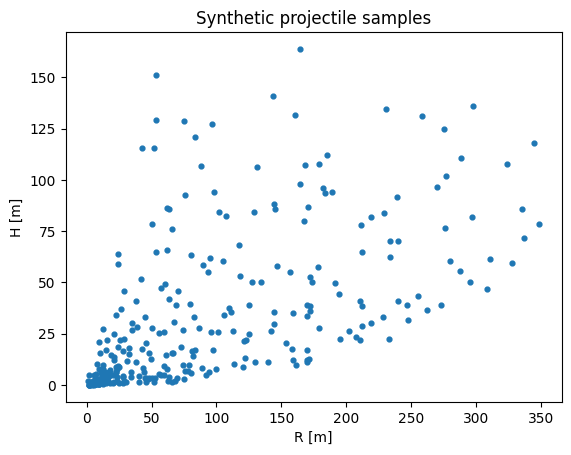

In [4]:
# --- Step 0: imports & knobs ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 可调参数
N = 300                         # 样本数
g = 9.81                        # 重力加速度 [m/s^2]
v0_min, v0_max = 5.0, 60.0      # 初速度范围 [m/s]
th_min_deg, th_max_deg = 5.0, 85.0  # 角度范围 [deg]
seed = 42                       # 随机种子（复现实验）

# --- Step 1: generate samples ---
rng = np.random.default_rng(seed)
v0 = rng.uniform(v0_min, v0_max, size=N)
theta_deg = rng.uniform(th_min_deg, th_max_deg, size=N)
theta = np.deg2rad(theta_deg)

# 抛体运动（无阻力）的解析关系
R = (v0**2) * np.sin(2 * theta) / g
H = (v0**2) * (np.sin(theta)**2) / (2 * g)

# 如果想模拟测量噪声，可取消注释：
# R += rng.normal(0, 0.5, size=N)   # 射程噪声 [m]
# H += rng.normal(0, 0.2, size=N)   # 高度噪声 [m]

# --- Step 2: pack to DataFrame ---
df = pd.DataFrame({
    "v0_mps": v0,
    "theta_deg": theta_deg,
    "R_m": R,
    "H_m": H,
    "g_mps2": g
})

# --- Step 3: save & quick look ---
csv_path = "ift_projectile_samples.csv"
df.to_csv(csv_path, index=False)
print(f"Saved to {csv_path}")
display(df.head())

# --- Step 4: quick scatter plot (R vs H) ---
plt.figure()
plt.scatter(df["R_m"], df["H_m"], s=12)
plt.xlabel("R [m]")
plt.ylabel("H [m]")
plt.title("Synthetic projectile samples")
plt.show()


### 隐函数显式组合的存在性与稳定性筛选

## 1️⃣ 为什么先要选基点 $(x_0, y_0)$

* **隐函数定理是局部结果**：它不保证全局解，只保证在某个点附近存在唯一解 $y = g(x)$。
* 基点 $(x_0, y_0)$ 就是你检验这个局部可解性的“起始位置”，它必须满足：

  $$
  F(x_0, y_0) = 0
  $$

  也就是说，这个点在你的约束曲面（或流形）上。
---

## 2️⃣ 基点的作用

* **检验可解性条件**：
  在 $(x_0, y_0)$ 处计算 $J_yF(x_0, y_0)$，判断它是否可逆：

  $$
  \det J_yF(x_0, y_0) \neq 0
  $$

  如果成立，就能在该点附近把 $y$ 表示成 $x$ 的函数。
* **确定局部近似**：
  基点给了你线性化的中心，可以用

  $$
  \mathrm{d}y = - J_y^{-1} J_x\, \mathrm{d}x
  $$

  得到 $g'(x_0)$，作为切平面或一阶近似。
* **后续分区依据**：
  如果在不同区域选择不同的基点，可能会得到不同的 $x/y$ 分块方式，这就是**自动分区实验域**的基础。

---



**可解性条件（对 $y$ 可解）**：计算 $J_y=\partial F/\partial (v_0,\theta)$ 的行列式：

$$
\det J_y=\frac{2 v_0^3 \sin^2\theta}{g^2}.
$$

因此只要 $v_0\neq 0$ 且 $\sin\theta\neq 0$（即 $\theta\notin\{0,\pi\}$），就满足隐函数定理：在该基点附近可以局部写成 $y=g(x)$。


In [7]:
# Step: 定义 F 与 Jy，并在一条样本基点上检查 det(Jy)≠0
import sympy as sp
import numpy as np

# 1) 符号定义与方程
R, H, v0, th, g = sp.symbols('R H v0 th g', real=True)
F1 = R - (v0**2)*sp.sin(2*th)/g
F2 = H - (v0**2)*(sp.sin(th)**2)/(2*g)
F = sp.Matrix([F1, F2])

y = sp.Matrix([v0, th])
Jy = F.jacobian(y)                 # ∂F/∂y
det_Jy = sp.simplify(sp.det(Jy))   # 行列式（可解性判据）
print("Symbolic det(Jy) =", det_Jy)

# 2) 数值化函数
F_func     = sp.lambdify((R, H, v0, th, g), F, 'numpy')
Jy_func    = sp.lambdify((R, H, v0, th, g), Jy, 'numpy')
detJy_func = sp.lambdify((R, H, v0, th, g), det_Jy, 'numpy')

# 3) 取数据表第一行作为基点 (x0, y0)
row = df.iloc[0]
R0, H0      = float(row["R_m"]), float(row["H_m"])
v00         = float(row["v0_mps"])
th0         = np.deg2rad(float(row["theta_deg"]))  # 注意转换为弧度
g0          = float(row["g_mps2"])

# 4) 基点可解性判定
F_val   = np.array(F_func(R0, H0, v00, th0, g0), dtype=float).ravel()
Jy_val  = np.array(Jy_func(R0, H0, v00, th0, g0), dtype=float)
det_val = float(detJy_func(R0, H0, v00, th0, g0))

print("F(x0,y0) =", F_val)                # 应接近 0（无噪声时精确为 0）
print("Jy(x0,y0) =\n", Jy_val)
print("det(Jy)(x0,y0) =", det_val)

eps_F, eps_J = 1e-8, 1e-10
invertible = (np.linalg.norm(F_val) < eps_F) and (abs(det_val) > eps_J)
print("Locally solvable for y at (x0,y0)?", invertible)


R - v0**2*sin(2*th)/g


### 下边的代码是使用sympy进行符号计算的过程

**Step 0：** 先列出参数，噪声，输出内容等数据

In [11]:
# ===============================================
# Implicit-function existence & stability screening
# (Projectile motion, drag-free) — with comments
# ===============================================

# --- Step 0: imports & knobs ---
import numpy as np
import pandas as pd
import sympy as sp
import matplotlib.pyplot as plt

from itertools import combinations
from numpy.linalg import inv, cond, norm, LinAlgError

# ===== 可调参数 =====
N = 300                          # 样本数
g_val = 9.81                     # 重力加速度 [m/s^2]
v0_min, v0_max = 5.0, 60.0       # 初速度范围 [m/s]
th_min_deg, th_max_deg = 5.0, 85.0  # 发射角范围 [deg]
seed = 42                        # 随机种子（复现实验）

add_noise = False                # 是否添加观测噪声
noise_R = 0.5                    # 射程噪声 [m]
noise_H = 0.2                    # 最高点噪声 [m]

save_csv = True                  # 是否保存CSV
make_plots = True                # 是否画图（直方图）

# 数值阈值（行列式与可解性）
EPS_DET = 1e-12




Matrix([[R - v0**2*sin(2*th)/g], [H - v0**2*sin(th)**2/(2*g)]])


**Step 1：** 对采样点进行数据生成，写入物理方程

  $$
  R = \frac{v_0^2\sin(2\theta)}{g}, \quad H = \frac{v_0^2\sin^2\theta}{2g}
  $$

In [12]:
# --- Step 1: generate samples (synthetic, no-drag) ---
rng = np.random.default_rng(seed)

# 物理原始变量：v0, theta
v0 = rng.uniform(v0_min, v0_max, size=N)
theta_deg = rng.uniform(th_min_deg, th_max_deg, size=N)
theta = np.deg2rad(theta_deg)   # 统一用弧度做计算

# 无阻力抛体关系
R = (v0**2) * np.sin(2 * theta) / g_val
H = (v0**2) * (np.sin(theta)**2) / (2 * g_val)

# 可选：加入观测噪声（模拟实验测量）
if add_noise:
    R = R + rng.normal(0, noise_R, size=N)
    H = H + rng.normal(0, noise_H, size=N)

df = pd.DataFrame({
    "v0_mps": v0,
    "theta_deg": theta_deg,
    "R_m": R,
    "H_m": H,
    "g_mps2": g_val
})

if save_csv:
    df.to_csv("ift_projectile_samples.csv", index=False)

**Step 2：** 创建符号矩阵，计算Jacobian


**雅可比矩阵的定义**

在隐函数场景下，**雅可比矩阵（Jacobian matrix）** 可以理解为把“多个方程对多个变量的偏导”排成一个矩阵，用来描述函数在某个点的 **局部线性化** 特性。

假设你有一个向量函数

$$
\mathbf{F}(\mathbf{x}) =
\begin{bmatrix}
F_1(x_1,\dots,x_n) \\
F_2(x_1,\dots,x_n) \\
\vdots \\
F_m(x_1,\dots,x_n)
\end{bmatrix}
$$

它的雅可比矩阵定义为：

$$
J(\mathbf{x}) =
\frac{\partial \mathbf{F}}{\partial \mathbf{x}} =
\begin{bmatrix}
\frac{\partial F_1}{\partial x_1} & \frac{\partial F_1}{\partial x_2} & \cdots & \frac{\partial F_1}{\partial x_n} \\
\frac{\partial F_2}{\partial x_1} & \frac{\partial F_2}{\partial x_2} & \cdots & \frac{\partial F_2}{\partial x_n} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial F_m}{\partial x_1} & \frac{\partial F_m}{\partial x_2} & \cdots & \frac{\partial F_m}{\partial x_n}
\end{bmatrix}
$$


* 对于标量函数（梯度）：Jacobian 退化成梯度向量。
* 对于向量函数：Jacobian 描述了输入空间的一个小邻域被函数映射到输出空间的**方向拉伸与压缩**。

---

**示例**

- 先使用sympy的symbols()进行映射。
- 将物理方程$F_1$, $F_2$进行sympy化。
- 组装物理模型为2x1的矩阵
$$
F =
\begin{bmatrix}
F_1 \\
F_2
\end{bmatrix}
=
\begin{bmatrix}
R - \dfrac{v_0^2 \sin(2\theta)}{g} \\
H - \dfrac{v_0^2 \sin^2\theta}{2g}
\end{bmatrix}
$$

之后**对Jacobian进行求解**：

$$
J_{\text{all}}=
\begin{bmatrix}
\frac{\partial F_1}{\partial R} & \frac{\partial F_1}{\partial H} & \frac{\partial F_1}{\partial v_0} & \frac{\partial F_1}{\partial \theta}\\[6pt]
\frac{\partial F_2}{\partial R} & \frac{\partial F_2}{\partial H} & \frac{\partial F_2}{\partial v_0} & \frac{\partial F_2}{\partial \theta}
\end{bmatrix}
=
\begin{bmatrix}
1 & 0 & -\dfrac{2 v_0 \sin(2\theta)}{g} & -\dfrac{2 v_0^2 \cos(2\theta)}{g} \\
0 & 1 & -\dfrac{v_0 \sin^2\theta}{g} & -\dfrac{v_0^2 \sin(2\theta)}{2g}
\end{bmatrix}
$$


---


In [14]:
# --- Step 2: define F symbolically & prebuild Jacobian ---
# F: R^2 x R^2 -> R^2, 在这里我们关心变量集合 [R, H, v0, th] 的偏导整体
# 当前只是创建符号的映射关系，并且声明这些变量为实数。
R_s, H_s, v0_s, th_s, g_s = sp.symbols('R H v0 th g', real=True)

F1 = R_s - (v0_s**2) * sp.sin(2*th_s) / g_s
F2 = H_s - (v0_s**2) * (sp.sin(th_s)**2) / (2*g_s)
# 创建一个符号矩阵，可以进行矩阵加减乘、求逆、求行列式等。
# 这里传入[F1, F2]，得到一个2x1的列向量
F = sp.Matrix([F1, F2])  # 2x1

# 对 [R, H, v0, th] 一次性求雅可比，便于之后切片出 Jy 与 Jx
all_vars = [R_s, H_s, v0_s, th_s]      # 顺序要与实际切片一致
J_all = F.jacobian(all_vars)           # 2x4

print("\nJ_all = ∂F/∂[R, H, v0, th] (2x4):")
sp.pprint(J_all)


J_all = ∂F/∂[R, H, v0, th] (2x4):
⎡                               2             ⎤
⎢      -2⋅v₀⋅sin(2⋅th)     -2⋅v₀ ⋅cos(2⋅th)   ⎥
⎢1  0  ────────────────    ─────────────────  ⎥
⎢             g                    g          ⎥
⎢                                             ⎥
⎢              2            2                 ⎥
⎢       -v₀⋅sin (th)     -v₀ ⋅sin(th)⋅cos(th) ⎥
⎢0  1   ─────────────    ─────────────────────⎥
⎣             g                    g          ⎦


---

**Step 3：** 变量分组 ** 隐函数显式化的前置工作

* 决定哪些变量要解 - **因变量** (independent variables)记为 **y**
* 决定哪些变量是已知 - **自变量** (dependent variables)记为 **x**

* 为什么隐函数定理会先分组？

隐函数定理告诉我们：

* 如果在某个基点 $(y_0, x_0)$ 处，雅可比矩阵

  $$
  J_y = \frac{\partial F}{\partial y}
  $$

  是可逆的（$\det(J_y) \neq 0$），
* 那么在这个基点附近，隐函数可以**局部显式化**成 $y = f(x)$。

所以：

1. **变量分组** → 明确 $J_y$ 要对哪些变量求偏导
2. **检查 $\det(J_y) \neq 0$** → 判断显式化是否可能
3. **显式化** → 真正解出 $y=f(x)$（解析或数值）

---

**例子**

$$
F_1(R,H,v_0,\theta) = 0, \quad F_2(R,H,v_0,\theta) = 0
$$

* 变量分组（比如 $y = [v_0,\theta], x = [R,H]$）只是说：

  > 我打算已知 $R,H$，去求 $v_0,\theta$。


In [15]:
# 选择要解的未知量 y = [v0, th]，以及已知量 x = [R, H]
idx_y = [2, 3]  # 在 all_vars 中 v0, th 的位置
idx_x = [0, 1]  # 在 all_vars 中 R, H 的位置

Jy = J_all[:, idx_y]  # 2x2
Jx = J_all[:, idx_x]  # 2x2

print("\nJy = ∂F/∂[v0, th] (2x2):")
sp.pprint(Jy)

print("\nJx = ∂F/∂[R, H] (2x2):")
sp.pprint(Jx)

# # --- 也可以进行批量的选择 ---
# # 这里示范“y 取两个变量，其余两个为 x”的情形：C(4,2)=6种
# candidate_y_blocks = list(combinations(range(4), 2))



Jy = ∂F/∂[v0, th] (2x2):
⎡                         2             ⎤
⎢-2⋅v₀⋅sin(2⋅th)     -2⋅v₀ ⋅cos(2⋅th)   ⎥
⎢────────────────    ─────────────────  ⎥
⎢       g                    g          ⎥
⎢                                       ⎥
⎢        2            2                 ⎥
⎢ -v₀⋅sin (th)     -v₀ ⋅sin(th)⋅cos(th) ⎥
⎢ ─────────────    ─────────────────────⎥
⎣       g                    g          ⎦

Jx = ∂F/∂[R, H] (2x2):
⎡1  0⎤
⎢    ⎥
⎣0  1⎦


---

**Step 4：**  用 `lambdify` 变成可数值调用的函数
会把“符号表达式”转换成“可用 NumPy 计算的数值函数”。

你可以给定一组数值（例如$R, H, v_0, \theta, g$)，快速得到雅可比矩阵的数值。

In [19]:
import numpy as np

# ⑦ 把 J_all 符号表达式编译成可调用的数值函数
J_func = sp.lambdify((R_s, H_s, v0_s, th_s, g_s), J_all, 'numpy')

# ⑧ 随便给一组物理上合理的数值评估（单位自定，只要自洽）
R_val  = 100.0            # 例如 100 m
H_val  = 10.0             # 例如 10 m
v0_val = 30.0             # 30 m/s
th_val = np.deg2rad(45)   # 45 度
g_val  = 9.81             # 9.81 m/s^2

J_num = np.array(J_func(R_val, H_val, v0_val, th_val, g_val), dtype=float)

print("\nJ_all (numeric 2x4) at R=100, H=10, v0=30, th=45°, g=9.81:")
print(J_num)

# 同理也可以把 Jy、Jx lambdify 出来
Jy_func = sp.lambdify((R_s, H_s, v0_s, th_s, g_s), Jy, 'numpy')
Jx_func = sp.lambdify((R_s, H_s, v0_s, th_s, g_s), Jx, 'numpy')

Jy_num = np.array(Jy_func(R_val, H_val, v0_val, th_val, g_val), dtype=float)
Jx_num = np.array(Jx_func(R_val, H_val, v0_val, th_val, g_val), dtype=float)

print("\nJy (numeric 2x2):")
print(Jy_num)

print("\nJx (numeric 2x2):")
print(Jx_num)



J_all (numeric 2x4) at R=100, H=10, v0=30, th=45°, g=9.81:
[[ 1.00000000e+00  0.00000000e+00 -6.11620795e+00 -1.12352917e-14]
 [ 0.00000000e+00  1.00000000e+00 -1.52905199e+00 -4.58715596e+01]]

Jy (numeric 2x2):
[[-6.11620795e+00 -1.12352917e-14]
 [-1.52905199e+00 -4.58715596e+01]]

Jx (numeric 2x2):
[[1. 0.]
 [0. 1.]]


---

**Step 5：**  **可逆性判定：** $det(J_y)$的计算与数值检测（含阈值判断）

如果隐函数是：

$$
\mathbf{F}(\mathbf{x}, \mathbf{y}) = 0
$$

且在某个基点（**视作采样点**） $(\mathbf{x}_0,\mathbf{y}_0)$ 处，关于 $\mathbf{y}$ 的雅可比矩阵

$$
J_y = \frac{\partial \mathbf{F}}{\partial \mathbf{y}}
$$

是**可逆的**（满秩），那么根据隐函数定理，$\mathbf{y}$ 可以在该点附近唯一地表示成 $\mathbf{y} = g(\mathbf{x})$。

也就是说：

* **可逆** ⇒ 当地可以解出 $\mathbf{y}$ 对 $\mathbf{x}$ 的显式函数。
* **不可逆** ⇒ 可能存在奇异点、分叉、非唯一解。
* $J_y$ 可逆表示“在 $\mathbf{y}$ 方向上这个曲面是可解的”。
* $J_y$ 奇异表示曲面在该方向变得平坦或折叠，导致解的唯一性丢失。

---

在下边的代码中，我们通过可逆性和满秩来一同验证当前变量组合的可解性。

In [18]:
# --- 可逆性：det(Jy) ---

# 1) 象征式行列式（便于检查/化简/推导）
det_Jy_sym = sp.simplify(Jy.det())
print("\nSymbolic det(Jy) =")
sp.pprint(det_Jy_sym)

# 2) 数值版 det(Jy)
det_Jy_func = sp.lambdify((R_s, H_s, v0_s, th_s, g_s), det_Jy_sym, 'numpy')
det_Jy_val = float(det_Jy_func(R_val, H_val, v0_val, th_val, g_val))
print(f"\nNumeric det(Jy) at the chosen point = {det_Jy_val:.6e}")

# 3) 可解性判定（阈值可根据量纲/尺度调整）
#    注意：仅用 det != 0 在浮点下不可靠，因此用 |det| > tol 作为“数值可逆”的判断
tol = 1e-10
is_solvable = abs(det_Jy_val) > tol
print(f"Solvable (|det(Jy)| > {tol}): {is_solvable}")

# 4) 辅助：也可用秩判断“数值满秩”
rank_Jy = np.linalg.matrix_rank(Jy_num, hermitian=False)
print(f"rank(Jy) = {rank_Jy} (期待为 2 才数值可逆)")



Symbolic det(Jy) =
    3    2    
2⋅v₀ ⋅sin (th)
──────────────
       2      
      g       

Numeric det(Jy) at the chosen point = 2.805600e+02
Solvable (|det(Jy)| > 1e-10): True
rank(Jy) = 2 (期待为 2 才数值可逆)


---

**Step 5：**  **Jacobian 矩阵的条件数(Condition Number)** $det(J_y)$的计算与数值检测（含阈值判断）

在数值分析里它用来衡量矩阵的**数值稳定性**和**可逆性好坏**。

在隐函数、力学计算等场景中，cond(J) 是判断**局部解敏感性**的重要指标。

## 1. 定义

对于一个矩阵 $J$，其条件数（通常是 2-范数意义下）定义为：

$$
\mathrm{cond}(J) = \|J\|_2 \cdot \|J^{-1}\|_2
$$

如果 $J$ 是方阵，这个公式也可以写成：

$$
\mathrm{cond}(J) = \frac{\sigma_{\max}}{\sigma_{\min}}
$$

其中：

* $\sigma_{\max}$ 是最大奇异值（矩阵拉伸空间的最大比例）
* $\sigma_{\min}$ 是最小奇异值（最小拉伸比例）

---

## 2. 物理/几何意义

* $J$ 描述了输入空间 $\mathbf{x}$ 到输出空间 $\mathbf{F}(\mathbf{x})$ 的局部线性映射。
* $\mathrm{cond}(J)$ 衡量这个映射的**各方向拉伸比的悬殊程度**：

  * **cond ≈ 1**：各方向缩放比例差不多，映射接近等距，数值稳定。
  * **cond 很大**：某些方向几乎被压扁（σ\_min 很小），说明这个方向上的信息会被放大成很大的数值误差，矩阵接近奇异。

---

## 3. 在隐函数问题中的作用

在隐函数定理应用中：

* 我们通常关心 $J_y = \frac{\partial \mathbf{F}}{\partial \mathbf{y}}$。
* 当 $\mathrm{cond}(J_y)$ 很小时（接近 1），说明局部可逆且数值计算稳定。
* 当 $\mathrm{cond}(J_y)$ 很大时，即使 $\det(J_y) \neq 0$，数值上也会表现为**病态可逆**，容易出现大误差或不稳定解。
* 当 $\mathrm{cond}(J_y) \to \infty$ 时，σ\_min → 0，矩阵奇异，局部不可逆，通常意味着分叉点、临界状态。

---

## 4. 力学中的类比

条件数在力学上很像**刚度矩阵的病态性**：

* **cond 小** ⇒ 各自由度的刚度平衡，加载方向都可控。
* **cond 大** ⇒ 存在软模态（soft mode），某个方向的刚度很小，系统对该方向的扰动非常敏感，可能进入失稳/屈曲。

---

## 6. 常用判断标准

| cond(J) 大小       | 数值意义 | 物理解释（力学）  |
| ---------------- | ---- | --------- |
| $\approx 1$      | 非常稳定 | 方向各向同性    |
| $10^1 \sim 10^3$ | 可接受  | 稍有方向差异    |
| $10^4 \sim 10^8$ | 数值病态 | 存在软模态或强耦合 |
| $\to \infty$     | 奇异矩阵 | 不可逆、分叉点   |

---




In [23]:
# --- Step 5: 计算条件数 cond(Jy) ---

cond_Jy = np.linalg.cond(Jy_num)
print(f"\ncond(Jy) = {cond_Jy:.6e}")



cond(Jy) = 7.508484e+00


**Step 6：**  **Jacobian 矩阵的敏感性** 

$$S = -J^{-1}_y J_x$$

它给出“自变量微小变化 δx 对因变量 δy 的线性响应”：$\delta{y} = S \delta{x}$

In [24]:
# --- Step 6: 敏感性矩阵 S = - Jy^{-1} Jx ---

# 先切出 Jx（这里按 y=[v0, th], x=[R, H]）
idx_y = [2, 3]          # 因变量 v0, th
idx_x = [0, 1]          # 自变量 R, H
Jy = J_all[:, idx_y]    # 2x2
Jx = J_all[:, idx_x]    # 2x2

# 符号式敏感性：用 LUsolve 避免显式逆，更稳
S_sym = - Jy.LUsolve(Jx)        # 等价于 -(Jy.inv() * Jx)，但数值更稳
S_sym = sp.simplify(S_sym)

print("\nSymbolic Sensitivity S = -Jy^{-1} Jx:")
sp.pprint(S_sym)

# 数值版：lambdify 并代入基点
S_func  = sp.lambdify((R_s, H_s, v0_s, th_s, g_s), S_sym, 'numpy')
Jy_func = sp.lambdify((R_s, H_s, v0_s, th_s, g_s), Jy,     'numpy')  # 若你还想复用 Jy 数值
Jx_func = sp.lambdify((R_s, H_s, v0_s, th_s, g_s), Jx,     'numpy')

S_num  = np.array(S_func(R_val, H_val, v0_val, th_val, g_val), dtype=float)
Jy_num = np.array(Jy_func(R_val, H_val, v0_val, th_val, g_val), dtype=float)
Jx_num = np.array(Jx_func(R_val, H_val, v0_val, th_val, g_val), dtype=float)

print("\nS (numeric, 2x2) with rows [dv0, dth], cols [dR, dH]:")
print(S_num)

# --- 可选：归一化敏感性（相对变化），便于比较不同量纲/尺度 ---
# S_rel[i,j] = (∂y_i/∂x_j) * (x_j / y_i)
x_vec = np.array([R_val, H_val], dtype=float)     # 自变量基点
y_vec = np.array([v0_val, th_val], dtype=float)   # 因变量基点
S_rel_num = S_num * x_vec[None, :] / y_vec[:, None]

print("\nS_rel (relative sensitivity) where S_rel[i,j] = (∂y_i/∂x_j)*(x_j/y_i):")
print(S_rel_num)

# --- 可选：校验线性近似 δy ≈ S δx ---
# 举例: 让 R 增加 1%，H 不变，看看 δy 的线性预测
delta_x = np.array([0.01 * R_val, 0.0], dtype=float)
delta_y_lin = S_num @ delta_x
print("\nExample: R +1% (H fixed) → predicted [δv0, δth]:")
print(delta_y_lin)



Symbolic Sensitivity S = -Jy^{-1} Jx:
⎡     g        g         g     ⎤
⎢────────────  ── - ───────────⎥
⎢2⋅v₀⋅tan(th)  v₀         2    ⎥
⎢                   v₀⋅tan (th)⎥
⎢                              ⎥
⎢    -g              2⋅g       ⎥
⎢   ─────        ───────────   ⎥
⎢       2          2           ⎥
⎣   2⋅v₀         v₀ ⋅tan(th)   ⎦

S (numeric, 2x2) with rows [dv0, dth], cols [dR, dH]:
[[ 1.63500000e-01 -5.55111512e-17]
 [-5.45000000e-03  2.18000000e-02]]

S_rel (relative sensitivity) where S_rel[i,j] = (∂y_i/∂x_j)*(x_j/y_i):
[[ 5.45000000e-01 -1.85037171e-17]
 [-6.93915552e-01  2.77566221e-01]]

Example: R +1% (H fixed) → predicted [δv0, δth]:
[ 0.1635  -0.00545]


In [ ]:
# J_funcs = sp.lambdify((R_s, H_s, v0_s, th_s, g_s), J_all, 'numpy')

# # 变量名称（用于展示）
# var_names = ['R', 'H', 'v0', 'th']


# # --- Step 4: evaluation function ---
# def evaluate_block(y_idx_pair, df, eps_det=EPS_DET):
#     """
#     对特定的 y-block（两个变量）做存在性与稳定性评估：
#     - 可解性：det(Jy) != 0
#     - 稳定性：cond(Jy), ||Jy^{-1}||_2, ||-Jy^{-1} Jx||_2

#     返回：
#     - diag_df: 每个样本的逐点诊断
#     - summary: 该组合的整体统计（用于排序）
#     """
#     y_idx = list(y_idx_pair)
#     x_idx = [i for i in range(4) if i not in y_idx]

#     y_names = [var_names[i] for i in y_idx]
#     x_names = [var_names[i] for i in x_idx]

#     rows = []
#     det_list, cond_list, gain_list, amp_list, inv_flags = [], [], [], [], []

#     for i in range(len(df)):
#         # 取样本点（注意 theta 用弧度代入符号函数）
#         R0 = float(df.loc[i, 'R_m'])
#         H0 = float(df.loc[i, 'H_m'])
#         v00 = float(df.loc[i, 'v0_mps'])
#         th0 = float(np.deg2rad(df.loc[i, 'theta_deg']))
#         g0  = float(df.loc[i, 'g_mps2'])

#         # 2x4 雅可比矩阵
#         J_all_np = np.array(J_funcs(R0, H0, v00, th0, g0), dtype=float)

#         # 切出 Jy (2x2), Jx (2x2)
#         Jy = J_all_np[:, y_idx]     # 对 y 的偏导
#         Jx = J_all_np[:, x_idx]     # 对 x 的偏导

#         # 可解性：det(Jy) != 0（仅在 2x2 情形可用）
#         try:
#             det_val = float(np.linalg.det(Jy))
#         except LinAlgError:
#             det_val = np.nan

#         is_invertible = np.isfinite(det_val) and (abs(det_val) > eps_det)

#         # 稳定性指标：cond(Jy), ||Jy^{-1}||_2, ||-Jy^{-1} Jx||_2
#         if is_invertible:
#             try:
#                 Jy_inv = inv(Jy)
#                 kappa = cond(Jy)                  # 2-范数条件数
#                 gain  = norm(Jy_inv, 2)           # ||Jy^{-1}||_2：F扰动→y扰动
#                 amp   = norm(-Jy_inv @ Jx, 2)     # ||-Jy^{-1}Jx||_2：x扰动→y扰动
#             except LinAlgError:
#                 kappa, gain, amp = np.inf, np.inf, np.inf
#         else:
#             kappa, gain, amp = np.inf, np.inf, np.inf

#         rows.append({
#             'sample': i,
#             'R': R0, 'H': H0, 'v0': v00, 'th(rad)': th0,
#             'det(Jy)': det_val,
#             'invertible': is_invertible,
#             'cond(Jy)': kappa,
#             '||Jy^{-1}||_2': gain,
#             '||-Jy^{-1}Jx||_2': amp
#         })

#         det_list.append(det_val)
#         cond_list.append(kappa)
#         gain_list.append(gain)
#         amp_list.append(amp)
#         inv_flags.append(is_invertible)

#     diag_df = pd.DataFrame(rows)

#     # 统计函数（忽略 inf / nan）
#     def finite_percentile(arr, q):
#         arr = np.array([a for a in arr if np.isfinite(a)], dtype=float)
#         if arr.size == 0: return np.nan
#         return float(np.percentile(arr, q))

#     summary = {
#         'y_block': tuple(y_names),
#         'x_block': tuple(x_names),
#         'invertible_rate': float(np.mean(inv_flags)),
#         'median_cond': finite_percentile(cond_list, 50),
#         'p90_cond':    finite_percentile(cond_list, 90),
#         'median_gain': finite_percentile(gain_list, 50),
#         'p90_gain':    finite_percentile(gain_list, 90),
#         'median_amp':  finite_percentile(amp_list, 50),
#         'p90_amp':     finite_percentile(amp_list, 90),
#     }
#     return diag_df, summary

# # --- Step 5: evaluate all candidate blocks & rank ---
# summaries = []
# diagnostics = {}  # key: y_block(tuple of names) -> per-sample diagnostics

# for y_pair in candidate_y_blocks:
#     diag_df, summary = evaluate_block(y_pair, df, eps_det=EPS_DET)
#     summaries.append(summary)
#     diagnostics[summary['y_block']] = diag_df

# summary_df = pd.DataFrame(summaries)

# # 排序准则：可解率高优先 → 条件数中位数低 → 放大因子 p90 低
# summary_df = summary_df.sort_values(
#     by=['invertible_rate', 'median_cond', 'p90_amp'],
#     ascending=[False, True, True]
# ).reset_index(drop=True)

# # 可选：保存结果
# if save_csv:
#     summary_df.to_csv("implicit_block_screen_summary.csv", index=False)
#     # 保存 top 组合的逐样本诊断
#     top_block = tuple(summary_df.loc[0, 'y_block'])
#     diagnostics[top_block].to_csv(f"diagnostics_top_block_{'_'.join(top_block)}.csv", index=False)

# # --- Step 6: quick plots (optional) ---
# if make_plots:
#     top_block = tuple(summary_df.loc[0, 'y_block'])
#     top_diag = diagnostics[top_block]

#     # 只对有限值作直方图
#     finite_cond = top_diag['cond(Jy)'][np.isfinite(top_diag['cond(Jy)'])]
#     finite_amp  = top_diag['||-Jy^{-1}Jx||_2'][np.isfinite(top_diag['||-Jy^{-1}Jx||_2'])]

#     plt.figure()
#     plt.hist(np.log10(finite_cond), bins=30)
#     plt.xlabel('log10 cond(Jy)')
#     plt.ylabel('count')
#     plt.title(f'Conditioning distribution for y={top_block}')
#     plt.show()

#     plt.figure()
#     plt.hist(np.log10(finite_amp), bins=30)
#     plt.xlabel('log10 ||-Jy^{-1}Jx||_2')
#     plt.ylabel('count')
#     plt.title(f'Amplification ||-Jy^(-1)Jx|| for y={top_block}')
#     plt.show()

# # --- Step 7: 展示核心输出（可在Notebook中直接查看） ---
# summary_df.head()

In [9]:
# ===============================================
# Implicit-function existence & stability screening
# (General y/x dimensions; projectile motion example)
# ===============================================

import numpy as np
import pandas as pd
import sympy as sp
import matplotlib.pyplot as plt
from itertools import combinations
from numpy.linalg import svd, matrix_rank, pinv, norm

# -----------------------------
# 0) 可调参数
# -----------------------------
N = 300
g_val = 9.81
v0_min, v0_max = 5.0, 60.0
th_min_deg, th_max_deg = 5.0, 85.0
seed = 42

ADD_NOISE = False
noise_R = 0.5
noise_H = 0.2

SAVE_CSV   = False
MAKE_PLOTS = False

# —— 关键：设置 y 的维度（可选 1/2/3）——
Y_DIM = 2   # 例：设为 1 则 y 取 1 个变量；设为 3 则 y 取 3 个变量

# 数值阈值
EPS_FULLRANK = 1e-12  # 判定满秩的奇异值下限

rng = np.random.default_rng(seed)

# -----------------------------
# 1) 生成样本（无阻力抛体）
# -----------------------------
v0 = rng.uniform(v0_min, v0_max, size=N)
theta_deg = rng.uniform(th_min_deg, th_max_deg, size=N)
theta = np.deg2rad(theta_deg)

R = (v0**2) * np.sin(2 * theta) / g_val
H = (v0**2) * (np.sin(theta)**2) / (2 * g_val)

if ADD_NOISE:
    R = R + rng.normal(0, noise_R, size=N)
    H = H + rng.normal(0, noise_H, size=N)

df = pd.DataFrame({
    "v0_mps": v0,
    "theta_deg": theta_deg,
    "R_m": R,
    "H_m": H,
    "g_mps2": g_val
})
if SAVE_CSV:
    df.to_csv("ift_projectile_samples.csv", index=False)

# -----------------------------
# 2) 符号构造 F 及总雅可比 J_all（对 [R,H,v0,th]）
# -----------------------------
R_s, H_s, v0_s, th_s, g_s = sp.symbols('R H v0 th g', real=True)

F1 = R_s - (v0_s**2)*sp.sin(2*th_s)/g_s
F2 = H_s - (v0_s**2)*(sp.sin(th_s)**2)/(2*g_s)
F  = sp.Matrix([F1, F2])              # m=2 维

all_vars = [R_s, H_s, v0_s, th_s]     # 4 个候选变量的顺序
var_names = ['R', 'H', 'v0', 'th']

J_all = F.jacobian(all_vars)          # 2x4
J_func = sp.lambdify((R_s, H_s, v0_s, th_s, g_s), J_all, 'numpy')

m = F.shape[0]                        # 方程数（本例 m=2）

# -----------------------------
# 3) 生成所有候选 y-block（大小 = Y_DIM）
# -----------------------------
assert 1 <= Y_DIM <= 3, "Y_DIM 只能为 1/2/3（因为总共有4个变量，且需留出x）"
candidate_y_blocks = list(combinations(range(4), Y_DIM))

# -----------------------------
# 4) 评估函数（支持任意 y/x 维度）
# -----------------------------
def evaluate_block_general(y_idx_tuple, df, eps_rank=EPS_FULLRANK):
    """
    对任意 y/x 维度的组合进行诊断：
    - 计算 Jy (m x p), Jx (m x n)
    - 计算 SVD 奇异值、rank
    - 若 p==m 且 rank(Jy)==m：满足经典 IFT（局部唯一可解）
    - 否则：给出广义数值诊断（不宣称 IFT 可解）
    - 稳定性度量统一使用伪逆：
        * smin, smax, cond2 = smax/smin（smin<eps → cond=inf）
        * ||Jy^+||_2 = 1/smin（若 smin<eps → inf）
        * || -Jy^+ Jx ||_2
    返回：
      diag_df: 含逐样本诊断
      summary: 统计摘要（用于排序/比较）
    """
    y_idx = list(y_idx_tuple)
    x_idx = [i for i in range(4) if i not in y_idx]

    y_names = [var_names[i] for i in y_idx]
    x_names = [var_names[i] for i in x_idx]

    rows = []
    # 收集统计
    fullrank_flags = []     # 是否 rank(Jy)=min(m,p)
    ift_flags = []          # 是否满足“经典 IFT”（仅当 p==m 且 rank=m）

    cond_list = []
    smin_list, smax_list = [], []
    pinv_norm_list = []
    amp_list = []

    for i in range(len(df)):
        R0 = float(df.loc[i, 'R_m'])
        H0 = float(df.loc[i, 'H_m'])
        v00 = float(df.loc[i, 'v0_mps'])
        th0 = float(np.deg2rad(df.loc[i, 'theta_deg']))
        g0  = float(df.loc[i, 'g_mps2'])

        J = np.array(J_func(R0, H0, v00, th0, g0), dtype=float)  # 2x4
        Jy = J[:, y_idx]   # m x p
        Jx = J[:, x_idx]   # m x n

        # SVD (Jy) -> 奇异值 s1>=...>=sk
        try:
            U, svals, Vt = svd(Jy, full_matrices=False)
        except np.linalg.LinAlgError:
            svals = np.array([])
        rank_Jy = int(np.sum(svals > eps_rank))
        fullrank = (rank_Jy == min(Jy.shape))
        fullrank_flags.append(fullrank)

        # 经典 IFT 条件：p==m 且 rank(Jy)==m
        ift_ok = (Jy.shape[1] == m) and (rank_Jy == m)
        ift_flags.append(ift_ok)

        # 条件数、最小/最大奇异值
        if svals.size > 0:
            smax = float(np.max(svals))
            smin = float(np.min(svals))
            cond2 = np.inf if smin <= eps_rank else (smax / smin)
            pinv_norm = np.inf if smin <= eps_rank else (1.0 / smin)  # ||Jy^+||_2
        else:
            smax, smin, cond2, pinv_norm = np.nan, np.nan, np.inf, np.inf

        # 放大因子：|| -Jy^+ Jx ||_2
        try:
            Jy_pinv = pinv(Jy)      # 任意形状都可
            amp = norm(-Jy_pinv @ Jx, 2)
        except np.linalg.LinAlgError:
            amp = np.inf

        smax_list.append(smax)
        smin_list.append(smin)
        cond_list.append(cond2)
        pinv_norm_list.append(pinv_norm)
        amp_list.append(amp)

        rows.append({
            'sample': i,
            'R': R0, 'H': H0, 'v0': v00, 'th(rad)': th0,
            'rank(Jy)': rank_Jy,
            'full_rank(Jy)': fullrank,
            'IFT_applicable(square_and_full_rank)': ift_ok,  # 仅 p==m, rank==m 时为 True
            'smax(Jy)': smax, 'smin(Jy)': smin, 'cond2(Jy)': cond2,
            '||Jy^+||_2': pinv_norm,
            '||-Jy^+ Jx||_2': amp
        })

    diag_df = pd.DataFrame(rows)

    def finite_pct(arr, q):
        arr = np.array([a for a in arr if np.isfinite(a)], dtype=float)
        if arr.size == 0: return np.nan
        return float(np.percentile(arr, q))

    summary = {
        'y_block': tuple(y_names),
        'x_block': tuple(x_names),
        'y_dim': len(y_names),
        # 统计：满秩率、IFT 可用率
        'fullrank_rate(Jy)': float(np.mean(fullrank_flags)),
        'IFT_rate(square_and_full_rank)': float(np.mean(ift_flags)),
        # 条件数/奇异值/伪逆范数/放大因子（分位数）
        'median_cond2': finite_pct(cond_list, 50),
        'p90_cond2':    finite_pct(cond_list, 90),
        'median_smin':  finite_pct(smin_list, 50),
        'p10_smin':     finite_pct(smin_list, 10),
        'median_||Jy^+||_2': finite_pct(pinv_norm_list, 50),
        'p90_||Jy^+||_2':    finite_pct(pinv_norm_list, 90),
        'median_amp':        finite_pct(amp_list, 50),
        'p90_amp':           finite_pct(amp_list, 90),
    }
    return diag_df, summary

# -----------------------------
# 5) 全局扫描并排序
# -----------------------------
summaries = []
diagnostics_by_block = {}

for y_pair in candidate_y_blocks:
    diag_df, summary = evaluate_block_general(y_pair, df)
    summaries.append(summary)
    diagnostics_by_block[summary['y_block']] = diag_df

summary_df = pd.DataFrame(summaries)

# 排序策略：
# 1) IFT 可用率（只有 y_dim==m 时可能>0）优先
# 2) 再看 cond2 中位数（越小越好）
# 3) 再看放大因子 p90（越小越好）
summary_df = summary_df.sort_values(
    by=['IFT_rate(square_and_full_rank)', 'median_cond2', 'p90_amp'],
    ascending=[False, True, True]
).reset_index(drop=True)

# 可选：保存
if SAVE_CSV:
    summary_df.to_csv("implicit_block_screen_general_summary.csv", index=False)
    top_block = tuple(summary_df.loc[0, 'y_block'])
    diagnostics_by_block[top_block].to_csv(
        f"diagnostics_top_block_{'_'.join(top_block)}.csv", index=False
    )

# 可选：简单绘图（对 Top 组合）
if MAKE_PLOTS:
    top_block = tuple(summary_df.loc[0, 'y_block'])
    top_diag = diagnostics_by_block[top_block]
    finite_cond = top_diag['cond2(Jy)'][np.isfinite(top_diag['cond2(Jy)'])]
    finite_amp  = top_diag['||-Jy^+ Jx||_2'][np.isfinite(top_diag['||-Jy^+ Jx||_2'])]

    plt.figure()
    plt.hist(np.log10(finite_cond), bins=30)
    plt.xlabel('log10 cond2(Jy)')
    plt.ylabel('count')
    plt.title(f'Conditioning for y={top_block}')
    plt.show()

    plt.figure()
    plt.hist(np.log10(finite_amp), bins=30)
    plt.xlabel('log10 ||-Jy^+ Jx||_2')
    plt.ylabel('count')
    plt.title(f'Amplification ||-Jy^+ Jx|| for y={top_block}')
    plt.show()

# 浏览结果（Notebook 中直接显示）
summary_df.head()


,y_block,x_block,y_dim,fullrank_rate(Jy),IFT_rate(square_and_full_rank),median_cond2,p90_cond2,median_smin,p10_smin,median_||Jy^+||_2,p90_||Jy^+||_2,median_amp,p90_amp
0,"(R, H)","(v0, th)",2,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,112.003841,381.452539
1,"(H, v0)","(R, th)",2,1.0,1.0,5.477179,10.596539,0.953009,0.644041,1.049310,1.552748,70.911449,298.445302
2,"(R, v0)","(H, th)",2,1.0,1.0,22.811350,65.736231,0.242430,0.052023,4.124916,19.222648,216.158395,599.379913
3,"(v0, th)","(R, H)",2,1.0,1.0,42.363186,720.705353,2.464930,0.113530,0.405693,8.809491,0.405693,8.809491
4,"(H, th)","(R, v0)",2,1.0,1.0,152.472621,440.207544,0.953448,0.452976,1.048827,2.208880,3.103615,13.567313
